In [99]:
# Bibliotecas de uso general en el cuaderno
from pymoo.core.problem import Problem
import numpy as np
from myutils import *
import pickle
import os

import hashlib
import folium
from folium.plugins import MarkerCluster
from pyproj import Proj, transform
from functools import partial
from pymoo.indicators.hv import HV

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination import get_termination
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.operators.crossover.hux import HalfUniformCrossover

import numpy as np

from pymoo.core.problem import Problem

from pymoo.optimize import minimize

from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.selection.tournament import TournamentSelection


from pymoo.core.problem import ElementwiseProblem
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.duplicate import HashDuplicateElimination
from pymoo.core.repair import Repair
import numpy as np

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

In [100]:
instance_number = 7

In [101]:
path = '../GeoData/Instances/Instance_' + str(instance_number) + '.pkl'

with open(path, 'rb') as f:
    instance = pickle.load(f) 
    f.close()

In [102]:
# for k in instance.keys():
#     print(f"{k} = instance['{k}']")
origenes = instance['origenes']
destinos = instance['destinos']
origen_i_to_node = instance['origen_i_to_node']
origen_node_to_i = instance['origen_node_to_i']
destino_i_to_num = instance['destino_i_to_num']
destino_num_to_i = instance['destino_num_to_i']
destino_num_to_node = instance['destino_num_to_node']
destino_node_to_num = instance['destino_node_to_num']
capacidades = instance['capacidades']
demanda = instance['demanda']
matriz_OD = instance['matriz_OD']
rutas = instance['rutas']

In [103]:
class MinPMedian(ElementwiseProblem):

    def __init__(self, costs, cap, dem, assign_type = 'classic', max_cost = 9000, **kwargs):
        
        self.costs = costs
        self.num_bases, self.num_demand = costs.shape # Número de bases y colapsos
        self.capacities = cap
        self.demands = dem
        self.max_cost = max_cost
        self.map_to_bases = dict()
        self.assign_type = assign_type
        self.explored = set()
        self.classic_assign = dict()
        
        super().__init__(n_var=costs.shape[0], n_obj=2, n_ieq_constr=2, var_type=bool, **kwargs)
        
    def assign(self, sol, assign_type = None):

        costs = copy(self.costs)
        cap = copy(self.capacities)
        dem = copy(self.demands)
        z = copy(sol)
        # Indices de las bases marcadas con 1
        indices_bases = np.nonzero(z*1)[0]  
        
        # Si en algún momento se queda con menos de dos bases, se agregan nuevas aleatoriamente

        if len(indices_bases) < 2:
            # NUmero de bases a añadir aleatoriamente
            num_bases_to_add = np.random.randint(2, costs.shape[0]/2)
            
            # Mientras no se hayan agregado todas las bases
            while len(indices_bases) < num_bases_to_add:
                
                # Selecciona una base aleatoria
                new_base = np.random.randint(0, costs.shape[0])
                
                # Si la base no está en la lista de bases, se agrega
                if new_base not in indices_bases:
                    z[new_base] = 1
                    indices_bases = np.append(indices_bases, new_base)

        
        # Para cada punto de demanda (columna) ordenar las bases por costo,
        # es decir, mueve las filas, arriba las bases menos costosas por cada punto de demanda
        columnas = np.argsort(costs[indices_bases], axis = 0)

        # Obtener las bases más cercanas a cada colapso
        nearest_base = indices_bases[columnas]
        
        a = [-1 for _ in range(costs.shape[1])]

        
        if not assign_type:
            a_type = self.assign_type
        else:
            a_type = assign_type
        
        
        # Asignación clásica --------------------------------------------------------------------
        # ---------------------------------------------------------------------------------------
        if a_type == 'classic':
            
            new_indices = [i for i in range(costs.shape[1])]
            np.random.shuffle(new_indices)
                    
        
        
        # Asignación por urgencias --------------------------------------------------------------
        # ---------------------------------------------------------------------------------------
        elif a_type == 'urgencies':
    
            # Obtiene la matriz de costos ordenada por costo por cada punto de demanda
            # a diferencia de la otra matriz, no contiene el ìndice si no el valor
            nearest_base_value = np.sort(costs[indices_bases], axis=0)

            # Calculas las prioridades de los puntos de demanda
            priorities = nearest_base_value[1] - nearest_base_value[0]

            new_indices = np.argsort(priorities)[::-1]
            
        
        
        # Asignación por urgencias y capacidad ---------------------------------------------------
        # ---------------------------------------------------------------------------------------
        elif a_type == 'urgencies_cap':
            
            # Obtiene la matriz de costos ordenada por costo por cada punto de demanda
            # a diferencia de la otra matriz, no contiene el ìndice si no el valor
            nearest_base_value = np.sort(costs[indices_bases], axis=0)

            # Calculas las prioridades de los puntos de demanda
            priorities = nearest_base_value[1] - nearest_base_value[0]
            
            new_indices = np.argsort(dem)[::-1]
            
            # Ordena primero por demanda y luego por prioridad (urgencia)
            new_indices = np.lexsort((priorities, dem))[::-1]
            
            
            
        # Por cada punto de demanda, identifica la más cercana disponible
        for j in new_indices:
            
            # Recorre las bases (columnas)
            for i in range(nearest_base.shape[0]):
                
                # Si la base en la posición [j] tiene capacidad para atender el punto i, 
                # se asigna y se descuenta del vector de capacidades
                if cap[nearest_base[i][j]] >= dem[j]:
                    cap[nearest_base[i][j]] -= dem[j]
                    a[j] = nearest_base[i][j]
                    
                    # Se procede al siguiente punto de demanda
                    break
                
                # Si no hay capacidad, se procede a la siguiente base
                else:
                    continue
        
        
        
        
        # Reparación de solución ----------------------------------------------------------------
        # ---------------------------------------------------------------------------------------
        
        bases_dif, counts = np.unique(a, return_counts=True)
        
        # Verifica que todos los puntos de demanda hayan sido asignados
        for point, base in enumerate(a):
            
            # Si para un punto de demanda no se asignó base, o sólo se asignó ese
            # punto a la base, se habilita la base más cercana disponible
            
            if base == -1 or counts[bases_dif == base][0] == 1:
                
                bases_to_point = costs[:,point]
                nearest_base = np.argsort(bases_to_point)
                
                for b in nearest_base:
                    if cap[b] >= dem[point]:
                        cap[b] -= dem[point]
                        a[point] = b
                        z[b] = 1
                        break   
        
        # Vector de solución reparado:
        z = np.zeros(costs.shape[0])
        z[a] = 1
        
        # En caso de haber usado el método clásico, para asegurar congruencia entre vectores Z,
        # se guarda la asignación clásica en un diccionario, o se toma la que estaba
        if a_type == 'classic':
            hash_z = hashlib.sha256(z).hexdigest()
            
            if hash_z not in self.classic_assign:
                self.classic_assign[hash_z] = a
            else:
                a = self.classic_assign.get(hash_z)
        
        return a, z
            
    def costos_rutas(self, a):
        return [self.costs[i][j] for j,i in enumerate(a)]

    def f1(self, a):
        return  round(sum(self.costos_rutas(a)), 2)

    def f2(self, a):
        return int(len(np.unique(a)))
    
    def cons1(self, a):
        return max(self.costos_rutas(a)) - self.max_cost
    
    def cons2(self, a):
        vals, counts = np.unique(a, return_counts=True)
        return 2*len(vals) - self.num_demand
        
    def _evaluate(self, z, out, *args, **kwargs):
        
        assignment, _ = self.assign(copy(z), assign_type = self.assign_type)
        
        # print(x)
        f1 = self.f1(assignment)
        f2 = self.f2(assignment)
        g1 = self.cons1(assignment)
        g2 = self.cons2(assignment)

        out["F"] = [f1,f2]
        out["G"] = [g1, g2]

# Asigna, permite repetidos
class Repair_normal(Repair):
    
    def _do(self, problem, Z, **kwargs):

        Z_repaired = []
        
        for z in Z:
            eval_z = copy(z)

            _, zr = problem.assign(eval_z*1, assign_type = problem.assign_type)        
            Z_repaired.append(copy(zr.astype(bool)))

        return Z_repaired

# Asigna, no permite repetidos, si se repite, genera una nueva solución aleatoria
class Repair_add_new(Repair):
    
    def __init__(self, sampling = 'none'):
    
        self.sampling = sampling
        
        super().__init__()
    
    def _do(self, problem, Z, **kwargs):

        Z_repaired = []
        
        for z in Z:
            eval_z = copy(z)
            new_z = False
            
            while not new_z:
                _, zr = problem.assign(eval_z*1, assign_type = problem.assign_type)
                
                hash_z = hashlib.sha256(zr).hexdigest()
                
                if hash_z not in problem.explored:
                    new_z = True
                    problem.explored.add(hash_z)
                    Z_repaired.append(copy(zr.astype(bool)))
                else:
                    eval_z = self.sampling.do(problem, 1)[0].X


        return Z_repaired

# Asigna, no permite repetidos, si se repite, muta bits hasta que no se repita
class Repair_mutation(Repair):
    
    def __init__(self, prob= 0.5):
    
        self.prob = prob
        
        super().__init__()
    
    def _do(self, problem, Z, **kwargs):

        Z_repaired = []
        
        for z in Z:
            eval_z = copy(z)
            new_z = False
            
            while not new_z:
                _, zr = problem.assign(eval_z*1, assign_type = problem.assign_type)
                
                hash_z = hashlib.sha256(zr).hexdigest()
                
                if hash_z not in problem.explored:
                    new_z = True
                    problem.explored.add(hash_z)
                    Z_repaired.append(copy(zr.astype(bool)))
                else:
                    
                    ind_to_mutate = np.nonzero(eval_z)[0]
                    for i in ind_to_mutate:
                        if np.random.rand() < self.prob:
                            eval_z[i] = not eval_z[i]
                            
                            # encuentra otro índice para mutar
                            replace = np.random.randint(0, len(eval_z))
                            while replace in ind_to_mutate:
                                replace = np.random.randint(0, len(eval_z))

                            eval_z[replace] = not eval_z[replace]
                            

        return Z_repaired


In [104]:
poblacion = 200
descendencia = int(poblacion * (50/100))
prob_mutacion = 0.5
prob_cruce = 0.5
prob_init = 0.01
op_mutacion = BitflipMutation(prob=prob_mutacion)
op_cruce = UniformCrossover(prob=prob_cruce)
# op_cruce= HalfUniformCrossover(prob=prob_cruce)
inicializacion = BinaryRandomSampling_n(prob = prob_init)
#reparacion = Repair_normal()
#reparacion = Repair_add_new(sampling=inicializacion)
reparacion = Repair_mutation(prob = 0.5)


algorithm = NSGA2(
    pop_size = poblacion,
    n_offsprings = descendencia,
    sampling = inicializacion,
    crossover = op_cruce,
    mutation = op_mutacion,
    eliminate_duplicates = True,
    repair = reparacion,
)

In [105]:
problem = MinPMedian(matriz_OD, capacidades, demanda, 
                     assign_type='urgencies',
                     max_cost=9000)

termination = DefaultMultiObjectiveTermination(
    xtol=0.0001,
    cvtol=1e-9,
    ftol=0.0001,
    period=100,
    n_skip=100,
    n_max_gen=500,
    n_max_evals=100000
)

In [106]:
import signal

def optimizar(problem, algorithm, termination):
    try:
        # Si la función tarda demasiado tiempo, se activará la alarma
        signal.alarm(20*60)  # Cambia 5 por el tiempo límite en segundos
        
        res = minimize(problem,
                algorithm = algorithm,
                copy_algorithm = True,
                seed = 141579774,
                save_history = True,
                termination = termination,
                verbose = False
                )

        # Si la función termina antes del límite de tiempo, cancela la alarma
        signal.alarm(0)
        return res
    
    except Exception as e:

        #with open('errores.txt', 'w') as file:
         #   file.write(str(e) + '\n')
          #  file.write(str())

        return -1

# Configurar el manejador de la señal de alarma
def manejador_alarma(signum, frame):
    raise TimeoutError("El algoritmo tardó demasiado tiempo en ejecutarse")


signal.signal(signal.SIGALRM, manejador_alarma)
res = optimizar(problem, algorithm, termination)


In [107]:
res

In [108]:
max_num_bases = np.ceil(problem.num_demand/2)
max_f1, max_f2 = [problem.num_demand*problem.max_cost, max_num_bases + 1]

pf = copy(res.F)
pf[:,0] = pf[:,0]/max_f1
pf[:,1] = pf[:,1]/max_f2
pf = pf[pf[:,1].argsort()]
hipervolumen = HV(ref_point=[1,1])
hipervolumen_inv = 1 - hipervolumen(pf)
print("HV", hipervolumen_inv)

HV 0.559895512012012


In [109]:
for i,(j,k) in enumerate(zip(res.F,res.CV)):
    print(i,j,k)

0 [6.492385e+04 1.700000e+01] [0.]
1 [6.876443e+04 1.600000e+01] [0.]
2 [7.383078e+04 1.500000e+01] [0.]
3 [6.109927e+04 1.800000e+01] [0.]
4 [1.0028435e+05 1.1000000e+01] [0.]
5 [9.300503e+04 1.200000e+01] [0.]
6 [1.1216635e+05 1.0000000e+01] [0.]
7 [8.636197e+04 1.300000e+01] [0.]
8 [7.99231e+04 1.40000e+01] [0.]
9 [1.3924068e+05 8.0000000e+00] [0.]
10 [1.2420503e+05 9.0000000e+00] [0.]


In [110]:
mejor = np.argmin(res.F[:,1])
#mejor = 4
sol = res.X[mejor]
out = dict()
ar, _ = problem.assign(sol)
F, G = problem.evaluate(sol, out, return_values_of=["F", "G"])

print('F:', F.tolist(), 'G:', G.tolist())
print(res.algorithm.n_gen)
print(res.algorithm.n_iter)
print(res.exec_time)

F: [139240.68, 8.0] G: [-36.62800000000061, -21.0]
501
501
274.3980224132538


In [111]:
# for i, sol in enumerate(res.X):
#     out = dict()
#     ar, _ = problem.assign(sol)
#     print('-'*100)
#     print(sol)
#     print(np.unique(ar).tolist())
#     F, G = problem.evaluate(sol, out, return_values_of=["F", "G"])
    
#     print('F:', F.tolist(), 'G:', G.tolist(), i, res.CV[i])
#     print(res.F[i])
#     print(res.F[i] == F )

In [112]:
# Carga las pltbs
pltbs = gpd.read_file('../GeoData/PLTBs.gpkg', layer = 'PLTBs_nodes')

# Serializa los datos de tipo lista
pltbs['streets'] = pltbs['streets'].apply(json.loads)
pltbs['streets'] = pltbs['streets'].apply(lambda x: list(set(x)))
pltbs['oneway'] = pltbs['oneway'].apply(json.loads)
pltbs['length'] = pltbs['length'].apply(json.loads)
pltbs['capacity'] = pltbs['capacity'].apply(json.loads)
pltbs['grouped'] = pltbs['grouped'].apply(json.loads)
pltbs_grupos= [item for sublist in [ i for i in pltbs['grouped']] for item in sublist]
pltbs_nodos = list(pltbs['node'])
pltbs.set_index('node', inplace = True)

# Carga los colapsos
colapsos = gpd.read_file('../GeoData/Points_instances.gpkg', layer = 'Instance_' + str(instance_number))
colapsos.set_index('num', inplace = True)

nodos = gpd.read_file('../GeoData/graph_transport.gpkg', layer = 'nodes')
nodos.set_index('osmid', inplace = True)

print('Datos para la visualización cargados')

Datos para la visualización cargados


In [113]:
bases, counts = np.unique(ar, return_counts=True)
grupos = {origen_i_to_node[base]:i for i,base in enumerate(bases)}
bases = [origen_i_to_node[i] for i in bases]

destinos = [destino_i_to_num[i] for i in range(len(ar))]

gdf_bases = pltbs.loc[bases]
gdf_destinos = colapsos.loc[destinos]

demanda_dict = dict([(i, int(demanda[i])) for i in range(len(ar))])
gdf_destinos['demanda'] = gdf_destinos.index.map(demanda_dict)

num_to_grupo = dict()
for i,j in enumerate(ar):
    num_to_grupo[destino_i_to_num[i]] = grupos[origen_i_to_node[j]]
    
gdf_destinos['grupo'] = gdf_destinos.apply(lambda x: num_to_grupo[x.name], axis = 1)

In [114]:
from shapely.geometry import LineString

gdf_rutas = dict()

for j,i in enumerate(ar):
    node_base = origen_i_to_node[i]
    num_destino = destino_i_to_num[j]
    node_destino = destino_num_to_node[num_destino][1]
    
    df_ruta = rutas.get(node_destino, None)
    dist_ruta, ruta = get_route_from_df(df_ruta,node_base)
    ruta = [node_destino] + ruta
    ruta_coords = [nodos.loc[i].geometry.coords[0] for i in ruta]
    ruta_geom = LineString(ruta_coords)
    ruta_info = {'geometry':ruta_geom,
                 'length':dist_ruta,
                 'base': node_base,
                 'destino': num_destino,
                 'grupo': grupos[node_base]}
    gdf_rutas[num_destino] = ruta_info

gdf_rutas = pd.DataFrame.from_records([i for i in gdf_rutas.values()],index='destino')
gdf_rutas = gpd.GeoDataFrame(gdf_rutas, crs="EPSG:6369", geometry = 'geometry')
    

In [115]:
tiles = {'monoLight': f"https://api.mapbox.com/styles/v1/jmmorph/cln3g3fze06q801qiavzu96hz/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token=",
         'monoDark': f"https://api.mapbox.com/styles/v1/jmmorph/clms73x09059301qid5sc3s1p/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token="}
apiKey = "pk.eyJ1Ijoiam1tb3JwaCIsImEiOiJjbG4zcHRxd2swZGs4Mmpud2I5Y3pveXh2In0.2Y2mdcYrmV_h0sZkkSvLUg"


tiles_default = folium.TileLayer(
    tiles=tiles['monoLight']+apiKey,
    attr='Mapbox',
    name='Monochrome Light',
)

m = folium.Map(location=[19.3, -99.1332], zoom_start=10.3,tiles=tiles_default)


folium.TileLayer(
    tiles=tiles['monoDark']+apiKey,
    attr='Mapbox',
    name='Monochrome Dark',
).add_to(m)


m = gdf_destinos.explore(m = m,
                         name="Puntos de demanda",
                         popup=["num",'victimas','demanda'],
                         )

m = gdf_rutas.explore(m=m, column="grupo", cmap="gist_rainbow", name="Rutas", legend=False)

m = gdf_bases.explore(m = m,
                      name="Bases", 
                      popup=["streets"], 
                      color="red",
                      marker_kwds={"radius": 10, "fill": True, "color": "red", "fillOpacity": 0},
                    #   icon = folium.Icon(icon='star-of-life', prefix='fa', color='blue')
                      )


# Controlador de capas
folium.LayerControl().add_to(m)
m.save('mapa_test.html')
m

In [116]:
max_num_bases = np.ceil(problem.num_demand/2)
max_f1, max_f2 = [problem.num_demand*problem.max_cost, max_num_bases + 1]

pf = copy(res.F)
pf[:,0] = pf[:,0]/max_f1
pf[:,1] = pf[:,1]/max_f2
pf = pf[pf[:,1].argsort()]
ind = HV(ref_point=[1,1])
print("HV", 1-ind(pf))

HV 0.559895512012012


/tmp/ipykernel_44095/4064159223.py:33: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(id, hipervol[-1],


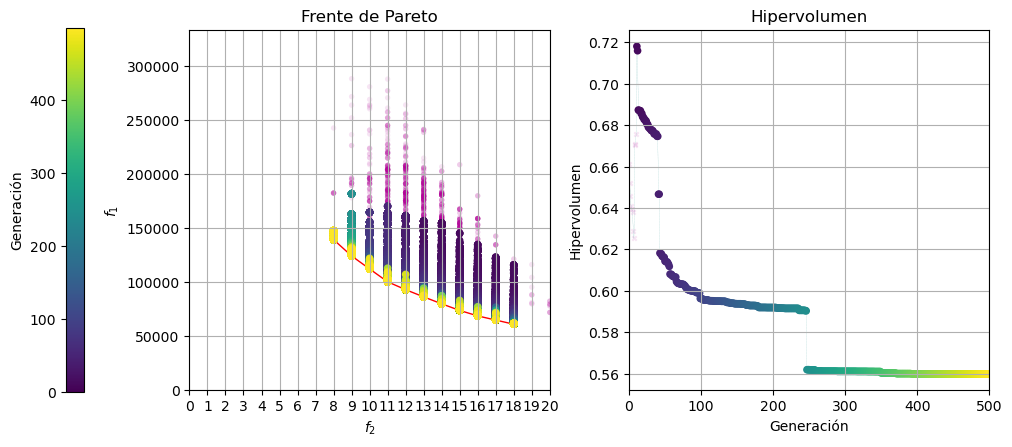

In [120]:
from matplotlib.cm import ScalarMappable


pf_cmap = plt.get_cmap('viridis')

fig,axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)


# transp = lambda x: (x[0],x[1],x[2],0.1)
transp = lambda x: (0.7,0,0.6,0.1)

hipervol = []
for id,r in enumerate(res.history):
    i = id/len(res.history)
    pfi = copy(r.pop.get("F"))
    pfi[:,0] = pfi[:,0]/max_f1
    pfi[:,1] = pfi[:,1]/max_f2
    
    indices_sort = np.argsort(pfi[:, 1])
    pfi = pfi[indices_sort]
    
    viol = copy(r.pop.get("CV"))
    viol = viol[indices_sort]
    
    hipervol.append(1-ind(pfi))
    
    colores_relleno = [pf_cmap(i) if j == 0 else transp(pf_cmap(i)) for j in viol]
    tamano = [30 if j == 0 else 15 for j in viol]
    
    axs[0].scatter(pfi[:, 1]*max_f2, pfi[:, 0]*max_f1, s=tamano, facecolors=colores_relleno, 
                   edgecolors='none')
    
    axs[1].scatter(id, hipervol[-1], 
                   marker=['x','o'][1*(np.sum(viol) == 0)],
                   s=[10,30][1*(np.sum(viol) == 0)],
                   facecolors=[pf_cmap(i), transp(pf_cmap(i))][1*(np.sum(viol) != 0)],
                   edgecolors='none',zorder=1)

    # if id == 0:
    #     axs[0].scatter(pfi[:, 1]*max_f2, pfi[:, 0]*max_f1, marker = 'x', color='r',zorder=0, label='Solucion inicial')
    
axs[0].plot(pf[:, 1]*max_f2, pf[:, 0]*max_f1, color='r',zorder=0, lw=1, ls='-', label='Frente final')

axs[0].set_box_aspect(1)
axs[0].set_xlabel('$f_2$')
axs[0].set_ylabel('$f_1$')
axs[0].set_xlim([0,max_f2])
axs[0].set_ylim([0,max_f1])
axs[0].set_title('Frente de Pareto')
axs[0].grid(True)
step = [1,2][(max_f2 > 20)*1]
axs[0].set_xticks([i for i in range(0,int(max_f2)+1,step)])

axs[1].set_box_aspect(1)
axs[1].plot(hipervol, color=pf_cmap(0.5),zorder=0, lw=0.1, ls='--')
axs[1].set_xlabel('Generación')
axs[1].set_ylabel('Hipervolumen')
axs[1].set_title('Hipervolumen')
axs[1].set_xlim([0,len(res.history)])
axs[1].grid(True)


# Añadimos una barra de colores
sm = ScalarMappable(cmap=pf_cmap, norm=plt.Normalize(0, len(res.history)-1))
sm.set_array([])  # Establecemos un array vacío

# Agregamos la barra de colores al eje
fig.colorbar(sm, ax=axs[0], label='Generación', location='left', shrink=0.74)



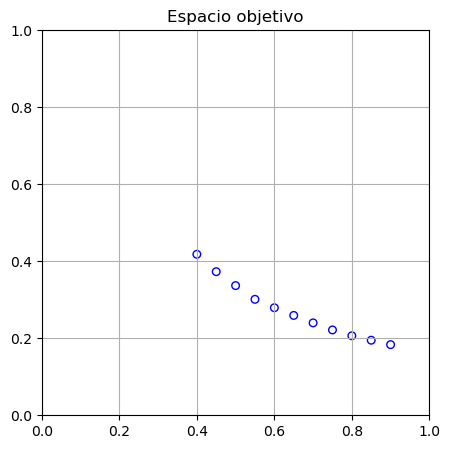

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(pf[:, 1], pf[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Espacio objetivo")
plt.grid()
plt.show()

In [119]:
K = '''from folium.plugins import MarkerCluster
from folium import Marker, Icon, Map

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:6369", "EPSG:4326")

tiles = {'monoLight': f"https://api.mapbox.com/styles/v1/jmmorph/cln3g3fze06q801qiavzu96hz/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token=",
         'monoDark': f"https://api.mapbox.com/styles/v1/jmmorph/clms73x09059301qid5sc3s1p/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token="}
apiKey = "pk.eyJ1Ijoiam1tb3JwaCIsImEiOiJjbG4zcHRxd2swZGs4Mmpud2I5Y3pveXh2In0.2Y2mdcYrmV_h0sZkkSvLUg"



tiles_default = folium.TileLayer(
    tiles=tiles['monoLight']+apiKey,
    attr='Mapbox',
    name='Monochrome Light',
)

m = folium.Map(location=[19.3, -99.1332], zoom_start=10.3,tiles=tiles_default)


folium.TileLayer(
    tiles=tiles['monoDark']+apiKey,
    attr='Mapbox',
    name='Monochrome Dark',
).add_to(m)



#m = gdf_rutas.explore(m=m, column="grupo", cmap="gist_rainbow", name="Rutas", legend=False)

m = gdf_bases.explore(m = m,
                      name="Bases", 
                      popup=["streets"], 
                      marker_kwds={"icon":'star-of-life',"color": "blue"},
                      )


feature_groups = dict()

for index, row in gdf_bases.iterrows():
    grupo = grupos[index]
    latitud = row['lat']
    longitud = row['lon']
    popup = [index,  row['capacity'], row['streets'],]

    # Crea un marcador
    marker = folium.Marker(location=[latitud, longitud], popup=popup, icon=folium.Icon(icon='star-of-life', prefix='fa', color='blue'))
    
    if grupo not in feature_groups.keys():
        feature_groups[grupo] = folium.FeatureGroup(name = 'Base ' + str(grupo))
        feature_groups[grupo].add_to(m)
        marker.add_to(feature_groups[grupo])
    else:
        feature_groups[grupo].add_child(marker)
    


# Itera sobre los datos del DataFrame
for index, row in gdf_destinos.iterrows():
    grupo = row['grupo']
    latitud = row['lat']
    longitud = row['lon']
    popup = row['demanda']

    # Crea un marcador
    marker = folium.Marker(location=[latitud, longitud], popup=popup,
                           icon=folium.Icon(icon='triangle-exclamation', prefix='fa', color='orange')
    if grupo not in feature_groups.keys():
        feature_groups[grupo] = folium.FeatureGroup(name = 'Base ' + str(grupo))
        feature_groups[grupo].add_to(m)
        marker.add_to(feature_groups[grupo])
    else:
        feature_groups[grupo].add_child(marker)


for index, row in gdf_rutas.iterrows():
    grupo = row['grupo']
    geometry = row['geometry']
    base_geom = gdf_bases.loc[row['base']].geometry.centroid
    # Convierte la geometría a coordenadas (latitud, longitud) en la nueva proyección
    coords_origen = [(point[0], point[1]) for point in geometry.coords]
    coords_destino = (transformer.transform(lat, lon) for lat, lon in coords_origen)
    coords_destino = [(lat, lon) for lat, lon in coords_destino]
    
    # Crea una polilínea y agrégala al MarkerCluster
    polyline = folium.PolyLine(locations=coords_destino, color='blue', weight=1).add_to(m)
    
    if grupo not in feature_groups.keys():
        feature_groups[grupo] = folium.FeatureGroup(name = 'Base ' + str(grupo))
        feature_groups[grupo].add_to(m)
        polyline.add_to(feature_groups[grupo])
    else:
        feature_groups[grupo].add_child(marker)



# Controlador de capas
folium.LayerControl().add_to(m)
m
'''